In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from tqdm import tqdm
import gc
import pickle

class Layer:
    def __init__(self):
        pass

    def forward(self, A):
        pass

    def backward(self, dZ):
        pass

class DenseLayer(Layer):
    def __init__(self, input_size, output_size, activation='relu'):
        self.W = np.random.randn(output_size, input_size) * np.sqrt(2/input_size) # He initialization
        self.b = np.zeros((output_size, 1))
        self.activation_function = ActivationLayer(activation)

    def forward(self, A):
        Z = self.W.dot(A) + self.b
        assert Z.shape == (self.W.shape[0], A.shape[1])
        return Z

    def backward(self, dZ, A_prev):
        m = A_prev.shape[1]
        dW = 1./m * np.dot(dZ, A_prev.T)
        db = 1./m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T, dZ)
        
        assert dA_prev.shape == A_prev.shape
        assert dW.shape == self.W.shape
        assert db.shape == self.b.shape
        
        return dA_prev, dW, db

class DropoutLayer(Layer):
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, A):
        self.mask = np.random.rand(*A.shape) > self.rate
        A = A * self.mask
        A /= (1 - self.rate)
        return A

    def backward(self, dA):
        dA = dA * self.mask
        dA /= (1 - self.rate)
        return dA

class ActivationLayer(Layer):
    def __init__(self, activation):
        self.activation = activation
        self.activation_cache = None

    def forward(self, Z):
        self.activation_cache = Z
        if self.activation == "relu":
            A = np.maximum(0, Z)
            assert A.shape == Z.shape
            return A
        elif self.activation == "sigmoid":
            A = 1 / (1 + np.exp(-Z))
            assert A.shape == Z.shape
            return A
        elif self.activation == "softmax":
            Z = np.clip(Z, -20, 20)
            e_x = np.exp(Z)
            A = e_x / np.sum(e_x, axis=0)
            assert A.shape == Z.shape
            return A + 1e-8

    def backward(self, dA):
        Z = self.activation_cache
        if self.activation == "relu":
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            assert dZ.shape == Z.shape
            return dZ
        elif self.activation == "sigmoid":
            s = 1 / (1 + np.exp(-Z))
            dZ = dA * s * (1 - s)
            assert dZ.shape == Z.shape
            return dZ
        elif self.activation == "softmax":
            # For this case, dA = Y_true
            Z = np.clip(Z, -20, 20)
            e_x = np.exp(Z)
            s = e_x / np.sum(e_x, axis=0)
            dZ = s - dA
            assert dZ.shape == Z.shape
            return dZ
class Network:
    def __init__(self):
        self.layers = []
        self.cache = []
        self.costs = []
        self.train_acc = []
        self.test_acc = []
        self.test_costs = []
        # For adam optimizer
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0
        self.optimizer = None

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X, training=True):
        A = X
        self.cache = [(None, X)]
        for layer in self.layers:
            if isinstance(layer, DropoutLayer) and training:
                A = layer.forward(A)
            elif isinstance(layer, DenseLayer):
                Z = layer.forward(A)
                A = layer.activation_function.forward(Z)
                self.cache.append((Z, A))
        assert A.shape == (26, X.shape[1])
        return A + 1e-8

    def backward(self, Y, AL):
        gradients = {}
        Y = Y.reshape(AL.shape)
        L = len(self.layers)
        dA_prev = Y  # Assuming last layer uses softmax
        self.cache.pop()
        for i in reversed(range(L)):
            layer = self.layers[i]
            if isinstance(layer, DropoutLayer):
                dA_prev = layer.backward(dA_prev)
            elif isinstance(layer, DenseLayer):
                self.t += 1
                Z, A_prev = self.cache.pop()
                dZ = layer.activation_function.backward(dA_prev)
                dA_prev, dW, db = layer.backward(dZ, A_prev)
                if self.optimizer == "adam":
                    gradients["vdW" + str(i+1)] = self.beta1 * gradients.get("vdW" + str(i+1), np.zeros_like(dW)) + (1 - self.beta1) * dW
                    gradients["vdb" + str(i+1)] = self.beta1 * gradients.get("vdb" + str(i+1), np.zeros_like(db)) + (1 - self.beta1) * db
                    gradients["sdW" + str(i+1)] = self.beta2 * gradients.get("sdW" + str(i+1), np.zeros_like(dW)) + (1 - self.beta2) * dW**2
                    gradients["sdb" + str(i+1)] = self.beta2 * gradients.get("sdb" + str(i+1), np.zeros_like(db)) + (1 - self.beta2) * db**2
                    vdW_corrected = gradients["vdW" + str(i+1)] / (1 - self.beta1**self.t)
                    vdb_corrected = gradients["vdb" + str(i+1)] / (1 - self.beta1**self.t)
                    sdW_corrected = gradients["sdW" + str(i+1)] / (1 - self.beta2**self.t)
                    sdb_corrected = gradients["sdb" + str(i+1)] / (1 - self.beta2**self.t)
                    dW = vdW_corrected / (np.sqrt(sdW_corrected) + self.epsilon)
                    db = vdb_corrected / (np.sqrt(sdb_corrected) + self.epsilon)
                gradients["dW" + str(i+1)] = dW
                gradients["db" + str(i+1)] = db
        return gradients

    def update_parameters(self, gradients):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                layer.W -= self.learning_rate * gradients["dW" + str(i+1)]
                layer.b -= self.learning_rate * gradients["db" + str(i+1)]

    def train(self, X_train, y_train, epochs, learning_rate=0.1, batch_size=64, valid_split=0.2, optimizer=None, decay_rate=0):
        self.learning_rate = learning_rate
        fixed_lr = learning_rate
        self.optimizer = optimizer
        X_train, y_train, X_valid, y_valid = self.train_test_split(X_train, y_train, valid_split=valid_split)
        num_examples = X_train.shape[1]
        num_batches = num_examples // batch_size
        for epoch in range(epochs):
            train_cost = 0
            self.learning_rate = fixed_lr * np.exp(-decay_rate*epoch)
            for j in tqdm(range(0, num_examples, batch_size)):
                start = j
                end = min(j+batch_size, num_examples)
                X_batch = X_train[:, start:end]
                y_batch = y_train[:, start:end]
                output = self.forward(X_batch)
                cost = self.compute_cost(output, y_batch)
                train_cost += cost
                gradients = self.backward(y_batch, output)
                self.update_parameters(gradients)

            # Compute cost and accuracy
            test_cost = self.compute_cost(self.forward(X_valid), y_valid)
            train_cost /= num_batches
            _, train_acc = self.predict(X_train, y_train)
            _, test_acc = self.predict(X_valid, y_valid)
            self.costs.append(train_cost)
            self.test_costs.append(test_cost)
            self.train_acc.append(train_acc)
            self.test_acc.append(test_acc)
            
            print(f'Epoch: {epoch+1}/{epochs}, train_cost: {train_cost:.5f}, test_cost: {test_cost:.5f}, train_acc: {train_acc:.5f}, test_acc: {test_acc:.5f}')
            
    def predict(self, X, y):
        m = X.shape[1]   # X = (768, m)
        # y = (26, m)
        y_hat = self.forward(X, training=False)
        p = np.argmax(y_hat, axis=0)
        y = np.argmax(y, axis=0)
        correct = np.sum(p == y)
        # print(f"train examples: {m}, correctly predicted: {correct}, accuracy: {correct/m}")
        return p, correct/m

    @staticmethod
    def compute_cost(AL, Y):
        m = Y.shape[1]
        cost = (-1./m) * np.sum(Y * np.log(AL))
        cost = np.squeeze(cost)
        assert cost.shape == ()
        return cost
    
    def train_test_split(self, X, y, valid_split=0.2):
        # Number of examples
        num_examples = X.shape[1]
        # Splitting the data
        valid_split = int(num_examples * valid_split)
        X_train = X[:, valid_split:]
        y_train = y[:, valid_split:]
        X_valid = X[:, :valid_split]
        y_valid = y[:, :valid_split]

        return X_train, y_train, X_valid, y_valid
    
    def plot_cost(self):
        plt.plot(np.squeeze(self.costs))
        plt.plot(np.squeeze(self.test_costs))
        plt.legend(['train', 'test'], loc='upper right')
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.title("Learning rate = " + str(self.learning_rate))
        plt.show()
        
    def plot_acc(self):
        plt.plot(np.squeeze(self.train_acc))
        plt.plot(np.squeeze(self.test_acc))
        plt.legend(['train', 'test'], loc='upper left')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title("Learning rate = " + str(self.learning_rate))
        plt.show()

    def save_model(self, filepath):
        self.cache.clear()
        self.costs.clear()
        self.train_acc.clear()
        self.test_acc.clear()
        self.test_costs.clear()
        for l in self.layers:
            if isinstance(l, DenseLayer):
                l.activation_function.activation_cache = None
            elif isinstance(l, DropoutLayer):
                l.mask = None
        gc.collect()
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

In [8]:
import torchvision.datasets as ds
import torchvision.transforms as transforms

# Load the EMNIST dataset for training and validation
train_validation_dataset = ds.EMNIST(root='./data', 
                                     split='letters',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Load the EMNIST dataset for independent testing
independent_test_dataset = ds.EMNIST(root='./data',
                                     split='letters',
                                     train=False,
                                     transform=transforms.ToTensor())
# 28x28 ==> 768, 1
# 28x28, 2


In [9]:
def extract_data_and_labels(dataset):
    # Initialize lists to store data and labels
    data = []
    labels = []

    # Loop through the dataset
    for image_tensor, label in dataset:
        # Flatten the image tensor and convert to numpy array
        flattened_image = image_tensor.numpy().flatten()
        data.append(flattened_image)
        labels.append(label)

    # Convert lists to numpy arrays
    return np.array(data), np.array(labels)

# Extract data and labels from the datasets
X_train_raw, y_train_raw = extract_data_and_labels(train_validation_dataset)
print(f'X_train shape: {X_train_raw.shape}')
print(f'y_train shape: {y_train_raw.shape}')

X_test_raw, y_test_raw = extract_data_and_labels(independent_test_dataset)
print(f'X_test shape: {X_test_raw.shape}')
print(f'y_test shape: {y_test_raw.shape}')


X_train shape: (124800, 784)
y_train shape: (124800,)
X_test shape: (20800, 784)
y_test shape: (20800,)


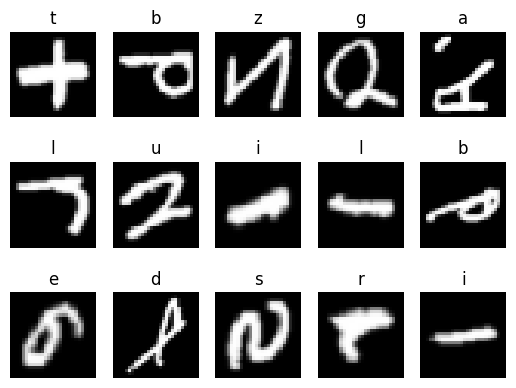

In [10]:
# plot some samples
import matplotlib.pyplot as plt
np.random.seed(1)

def plot_samples(X, y, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flatten()):
        random_index = np.random.randint(0, len(X))
        ax.imshow(X[random_index].reshape(28,28), cmap='gray')
        ax.set_title(chr(y[random_index]+96))
        ax.axis('off')
    plt.savefig('figures/1_training_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_samples(X_train_raw, y_train_raw, 3, 5)


In [11]:
m_train = X_train_raw.shape[0]
m_test = X_test_raw.shape[0]
num_px = X_train_raw.shape[1]


print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print(f'Number of pixels: {num_px}')
print ("train_set_x shape: " + str(X_train_raw.shape))
print ("train_set_y shape: " + str(y_train_raw.shape))
print ("test_set_x shape: " + str(X_test_raw.shape))
print ("test_set_y shape: " + str(y_test_raw.shape))


Number of training examples: 124800
Number of testing examples: 20800
Number of pixels: 784
train_set_x shape: (124800, 784)
train_set_y shape: (124800,)
test_set_x shape: (20800, 784)
test_set_y shape: (20800,)


In [12]:
X_train = X_train_raw.T
X_test = X_test_raw.T

print ("train_set_x_flatten shape: " + str(X_train.shape))
print("test_set_x_flatten shape: " + str(X_test.shape))

y_train = y_train_raw - 1
y_test = y_test_raw - 1

y_train = np.eye(26)[y_train.astype('int32')]
y_test = np.eye(26)[y_test.astype('int32')]
y_train = y_train.T
y_test = y_test.T
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_y shape: " + str(y_test.shape))

# Now shuffle the training set
np.random.seed(1)
permutation = list(np.random.permutation(m_train))
X_train = X_train[:, permutation]
y_train = y_train[:, permutation]
y_train_raw = y_train_raw[permutation]

train_set_x_flatten shape: (784, 124800)
test_set_x_flatten shape: (784, 20800)
train_set_y shape: (26, 124800)
test_set_y shape: (26, 20800)


In [61]:
# Example usage:
np.random.seed(1)
model = Network()
model.add(DenseLayer(input_size=X_train.shape[0], output_size=512))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=512, output_size=128))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=128, output_size=128))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=128, output_size=64))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=64, output_size=64))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=64, output_size=26, activation='softmax'))
# Assume X_train and y_train are defined
model.train(X_train, y_train, epochs=60, batch_size=1024, learning_rate=0.0005, valid_split=0.15, optimizer='adam', decay_rate=0.08)

# Example usage:
# np.random.seed(1)
# model = Network()
# model.add(DenseLayer(input_size=X_train.shape[0], output_size=1024))
# model.add(DropoutLayer(rate=0.25))
# model.add(DenseLayer(input_size=1024, output_size=256))
# model.add(DropoutLayer(rate=0.25))
# model.add(DenseLayer(input_size=256, output_size=128))
# model.add(DropoutLayer(rate=0.25))
# model.add(DenseLayer(input_size=128, output_size=64))
# model.add(DropoutLayer(rate=0.25))
# model.add(DenseLayer(input_size=64, output_size=32))
# model.add(DropoutLayer(rate=0.1))
# model.add(DenseLayer(input_size=32, output_size=26, activation='softmax'))
# # Assume X_train and y_train are defined
# model.train(X_train, y_train, epochs=60, batch_size=128, learning_rate=0.00001, valid_split=0.15, optimizer='adam')

  0%|          | 0/104 [00:00<?, ?it/s]

100%|██████████| 104/104 [00:09<00:00, 11.05it/s]


Epoch: 1/60, train_cost: 2.74155, test_cost: 1.97971, train_acc: 0.62019, test_acc: 0.61672


100%|██████████| 104/104 [00:09<00:00, 10.86it/s]


Epoch: 2/60, train_cost: 1.60079, test_cost: 1.26953, train_acc: 0.76941, test_acc: 0.76421


100%|██████████| 104/104 [00:09<00:00, 11.06it/s]


Epoch: 3/60, train_cost: 1.12618, test_cost: 1.05436, train_acc: 0.81988, test_acc: 0.80849


100%|██████████| 104/104 [00:09<00:00, 11.26it/s]


Epoch: 4/60, train_cost: 0.91662, test_cost: 0.90021, train_acc: 0.85449, test_acc: 0.84316


100%|██████████| 104/104 [00:09<00:00, 11.29it/s]


Epoch: 5/60, train_cost: 0.80746, test_cost: 0.79186, train_acc: 0.87337, test_acc: 0.86084


100%|██████████| 104/104 [00:09<00:00, 11.28it/s]


Epoch: 6/60, train_cost: 0.74000, test_cost: 0.77733, train_acc: 0.88539, test_acc: 0.86875


100%|██████████| 104/104 [00:09<00:00, 10.89it/s]


Epoch: 7/60, train_cost: 0.81024, test_cost: 0.99808, train_acc: 0.87078, test_acc: 0.85892


100%|██████████| 104/104 [00:09<00:00, 11.04it/s]


Epoch: 8/60, train_cost: 1.47650, test_cost: 2.67220, train_acc: 0.70088, test_acc: 0.69802


100%|██████████| 104/104 [00:09<00:00, 11.01it/s]


Epoch: 9/60, train_cost: 2.94003, test_cost: 3.03043, train_acc: 0.56538, test_acc: 0.56832


100%|██████████| 104/104 [00:09<00:00, 11.01it/s]


Epoch: 10/60, train_cost: 2.86059, test_cost: 2.87386, train_acc: 0.64464, test_acc: 0.64193


100%|██████████| 104/104 [00:09<00:00, 10.81it/s]


Epoch: 11/60, train_cost: 2.75093, test_cost: 2.80179, train_acc: 0.68744, test_acc: 0.68568


  0%|          | 0/104 [00:00<?, ?it/s]


KeyboardInterrupt: 

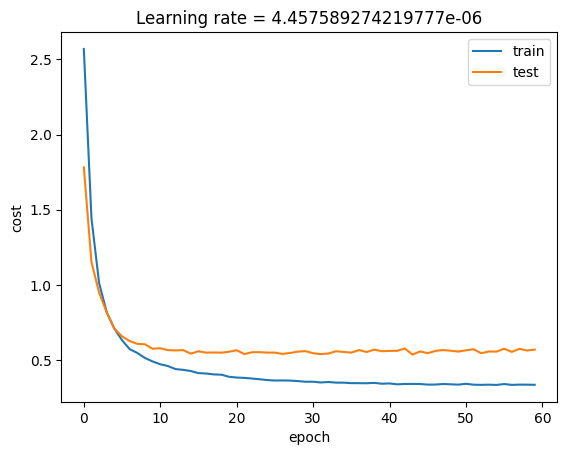

In [53]:
model.plot_cost()

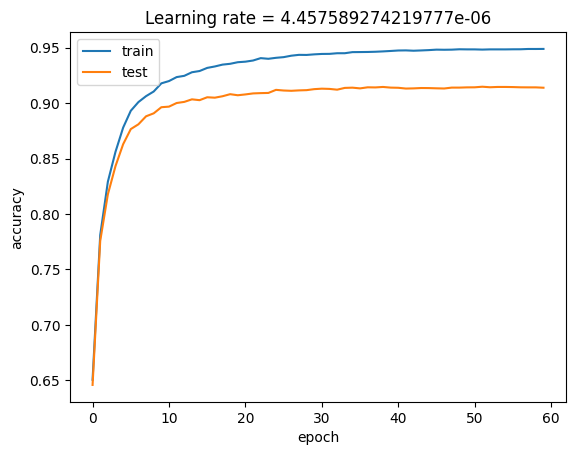

In [54]:
model.plot_acc()

In [55]:
y_hat, acc = model.predict(X_test, y_test)
print(f'Test accuracy: {acc}')

Test accuracy: 0.9113461538461538


In [56]:
y_hat, acc = model.predict(X_train, y_train)
print(f'Train accuracy: {acc}')

Train accuracy: 0.9435657051282051


Test accuracy: 0.9113461538461538


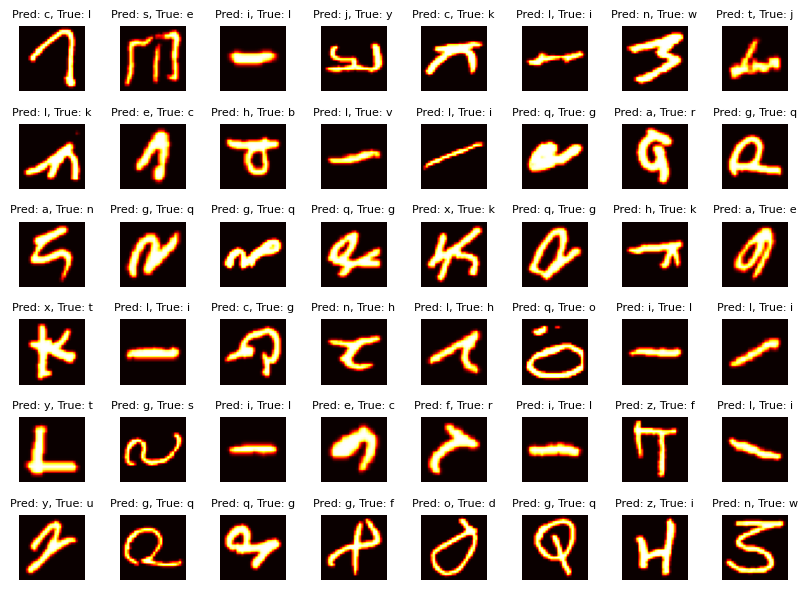

In [57]:
# visualize misclassified examples
def plot_misclassified(X, y, y_hat, nrows, ncols):
    np.random.seed(1)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(ncols, nrows)
    correctly_classified = np.where(y == y_hat)[0]
    misclassified = np.where(y != y_hat)[0]
    for i, ax in enumerate(axes.flatten()):
        random_index = np.random.choice(misclassified)
        ax.imshow(X[:, random_index].reshape(28,28), cmap='hot')
        ax.set_title(f'Pred: {chr(y_hat[random_index]+97)}, True: {chr(y[random_index]+97)}', fontsize=8)
        ax.axis('off')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

y_hat, acc = model.predict(X_test, y_test)
print(f'Test accuracy: {acc}')
plot_misclassified(X_test, y_test_raw - 1, y_hat, 6, 8)

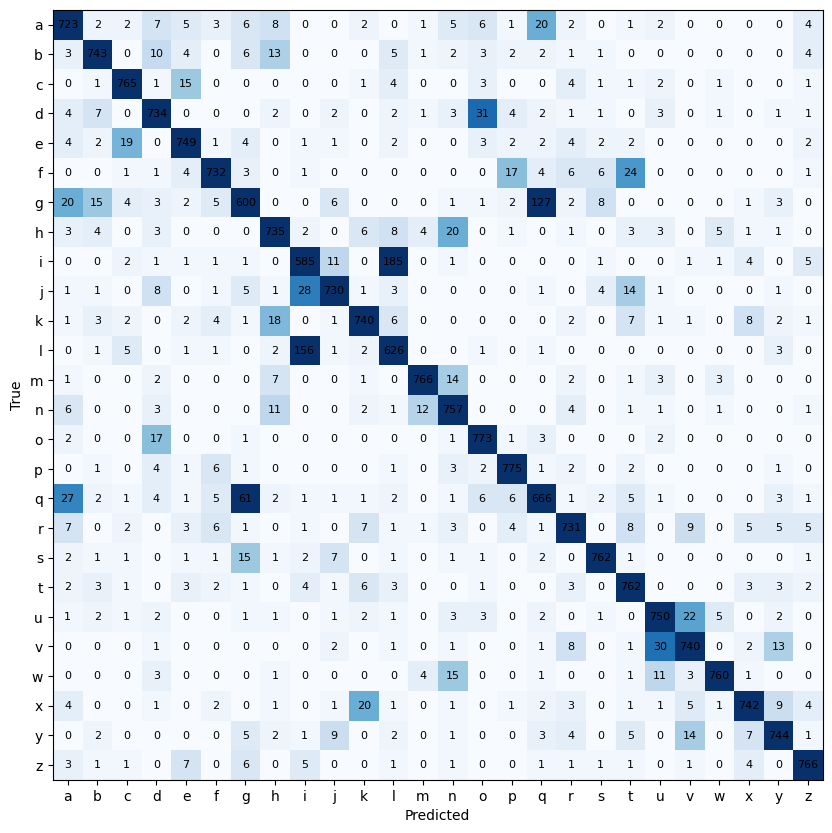

In [58]:
C_counts = confusion_matrix(y_test_raw - 1, y_hat)
C = confusion_matrix(y_test_raw - 1, y_hat, normalize='true')

fig = plt.figure(figsize=(10, 10))
plt.imshow(C, 'Blues', vmax=0.05)
# also show the numbers
for i in range(26):
    for j in range(26):
        plt.text(j, i, f'{C_counts[i, j]}', horizontalalignment='center', verticalalignment='center', fontsize=8)
plt.xticks(range(26), labels=[chr(i+97) for i in range(26)])
plt.yticks(range(26), labels=[chr(i+97) for i in range(26)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [59]:
# Calculate validation macro F1 score
# Use built-in sklearn function
y_hat, acc = model.predict(X_test, y_test)
print(f'Test accuracy: {acc}')
macro_f1 = f1_score(y_test_raw - 1, y_hat, average='macro')
print(f'Test macro F1 score: {macro_f1:.5f}')

Test accuracy: 0.9113461538461538
Test macro F1 score: 0.91139


In [60]:
model.save_model('f1_91.pkl')